In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# PGP script
import prec_to_blocks

100%|██████████| 343565/343565 [20:45<00:00, 275.93it/s]


In [3]:
blocks = gpd.read_file("./output/blocks_with_bg/blocks_with_bg.shp") #blocks with precinct labels
prec = gpd.read_file("./raw-from-source/mo_2016/mo_2016.shp")

In [4]:
# from clean.py to add "loc_prec" variable to precinct shapefile
prec["loc_prec"] = prec['COUNTYFP'] + ',' + prec['NAME']
prec['loc_prec'].nunique()
prec[prec.duplicated(['loc_prec'])]
prec.shape
prec[prec.duplicated(['loc_prec'])]
prec = prec.dissolve(by='loc_prec', as_index=False) #dissolve precincts with the same name

In [5]:
# PGP script
from areal_interpolation import aggregate
s,t = aggregate(source=blocks,target=prec, target_columns =["loc_prec"])

100%|██████████| 343565/343565 [20:31<00:00, 278.93it/s] 


In [6]:
s.to_file("./output/blocks_with_prec/mo_blocks_with_prec.shp")

In [7]:
# PGP script
import clean

In [8]:
# final shapefile produced in clean.py script
mo = gpd.read_file("./output/final_prec/prec_labeled.shp")

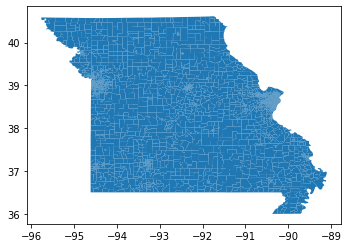

In [9]:
mo.plot()

## Validate

In [10]:
# Load PGPG MO shapefile to compare results
# https://github.com/PrincetonUniversity/gerryspam/tree/master/MO/dat/final_prec
final = gpd.read_file('./dat/final_prec/prec_labeled.shp')

In [11]:
validate = pd.merge(mo, final, on=['loc_prec'], how='outer',indicator=True)

**Fix slight name differences**

In [12]:
validate[validate._merge=="left_only"]["loc_prec"]

1291                 101,Columbus
1292                  101,Lowland
1293             101,North Holden
1295                 101,Post Oak
1296                  101,Simpson
1297    101,Warrensburg Southwest
Name: loc_prec, dtype: object

In [13]:
validate[validate._merge=="right_only"]["loc_prec"]

3256               101,Centerview/Columbus
3257                101,Hazel Hill/Simpson
3258               101,Knob Noster/Lowland
3259    101,NS Holden/Rose Hill/Kingsville
3260                101,Post Oak/Jefferson
3261       101,Warrensburg SE-1/Montserrat
3262               101,Warrensburg SE-2/NE
3263                 101,Warrensburg SW/NW
Name: loc_prec, dtype: object

In [14]:
ind = [final[final.loc_prec==name].index.tolist() for name in validate[validate._merge=="right_only"]["loc_prec"]]
ind = [i for i in ind for i in i]
ind.remove(1297) #no match
ind.remove(1298) #no match

In [15]:
mo_prec = validate[validate._merge=="left_only"]["loc_prec"].tolist()
reorder = [0, 2, 3, 4, 1, 5]
fix_prec = [mo_prec[i] for i in reorder]

In [16]:
final.loc[ind, 'loc_prec'] = fix_prec

In [17]:
# Try again with namings fixed
validate = pd.merge(mo, final, on=['loc_prec'], how='outer',indicator=True)

### Check population

In [18]:
validate['pop_diff'] = validate.POP10_x - validate.POP10_y

**Precincts match popultion**

In [19]:
validate[validate.pop_diff.abs()<1].shape[0] / validate.shape[0]

0.9978514426028238

### Check districts

In [75]:
#number of precincts assigned to state house districts that don't match PGP's
validate[['SLDLST_x', 'SLDLST_y']].assign(NE=validate.SLDLST_x != validate.SLDLST_y)['NE'].sum()

7

Five precincts assigned to state house districts do not match PGP's assignment (two did not join). 


Three of the five  (101,Lowland; 101,Simpson; and 101 Warrensburg Southwest) are split among house districts. 
Two precincts (101,North Holden; 101,Post Oak) are in house district 54; both PGP's and the replicated shapefile are slightly off in their assignment.

In [77]:
validate[validate[['SLDLST_x', 'SLDLST_y']].assign(NE=validate.SLDLST_x != validate.SLDLST_y)['NE']][["loc_prec",'SLDLST_x', 'SLDLST_y',"_merge"]]

,loc_prec,SLDLST_x,SLDLST_y,_merge
1292,"101,Lowland",50.0,53,both
1293,"101,North Holden",53.0,52,both
1295,"101,Post Oak",53.0,50,both
1296,"101,Simpson",52.0,53,both
1297,"101,Warrensburg Southwest",50.0,53,both
3256,"101,Warrensburg SE-1/Montserrat",NaN,50,right_only
3257,"101,Warrensburg SE-2/NE",NaN,50,right_only


In [21]:
#number of precincts assigned to state senate districts that don't match PGP's
validate[['SLDUST_x', 'SLDUST_y']].assign(NE=validate.SLDUST_x != validate.SLDUST_y)['NE'].sum()

2

The two precincts not matched to the same state upper chamber district as PGP's final shapefile are those that did not join

In [48]:
validate[validate[['SLDUST_x', 'SLDUST_y']].assign(NE=validate.SLDUST_x != validate.SLDUST_y)['NE']][["loc_prec","_merge"]]

,loc_prec,_merge
3256,"101,Warrensburg SE-1/Montserrat",right_only
3257,"101,Warrensburg SE-2/NE",right_only


In [22]:
#number of precincts assigned to congressional districts that don't match PGP's
validate[['CD115FP_x', 'CD115FP_y']].assign(NE=validate.CD115FP_x != validate.CD115FP_y)['NE'].sum()

2902

**Why are congressional districts not matching?**

In [24]:
from matplotlib import cm
color = cm.get_cmap('Paired',9)

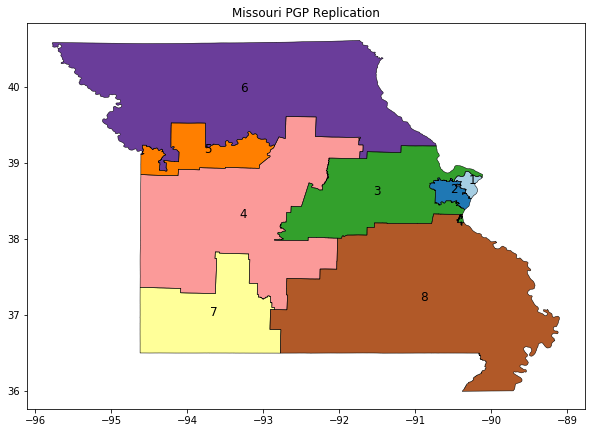

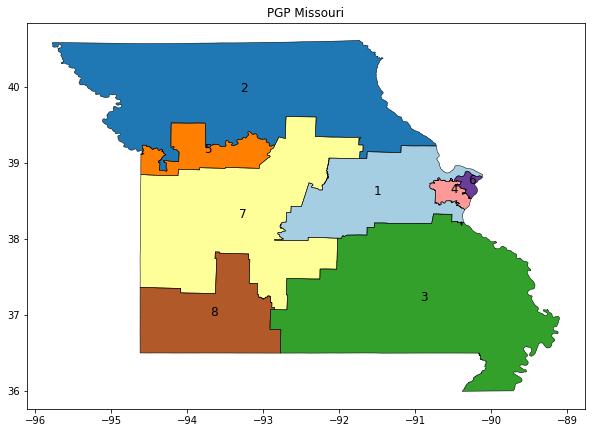

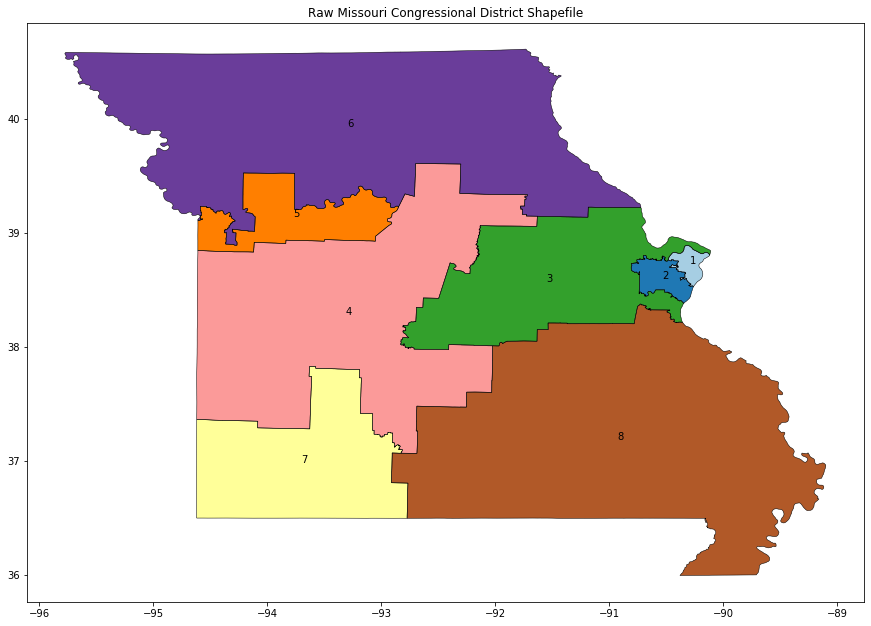

In [58]:
# MO replication 
mo['CD'] = mo['CD115FP']
cd = mo.dissolve(by='CD115FP')
cd = cd.sort_values('CD')
cd = cd.reset_index(drop=True)

axes = cd.boundary.plot(figsize=(10,10), color=None, edgecolor="black", linewidth=0.5)
cd.index.name = "index"
cd.plot(column="CD", cmap=color, ax=axes)

cd["center"] = cd["geometry"].centroid
mo_points = cd.copy()
mo_points.set_geometry("center", inplace = True)
texts=[]
for x,y,label in zip(mo_points.geometry.x, mo_points.geometry.y, mo_points.index+1):
    texts.append(plt.text(x,y,str(label), fontsize=11))
plt.title("Missouri PGP Replication");


# PGP's final MO
final['CD'] = final['CD115FP']
cd = final.dissolve(by='CD115FP')
axes = cd.boundary.plot(figsize=(15,15), color=None, edgecolor="black", linewidth=0.5)
cd.index.name = "index"
cd.plot(column="CD", cmap=color, ax=axes)

cd["center"] = cd["geometry"].centroid
mo_points = cd.copy()
mo_points.set_geometry("center", inplace = True)
texts=[]
for x,y,label in zip(mo_points.geometry.x, mo_points.geometry.y, mo_points.index+1):
    texts.append(plt.text(x,y,str(label), fontsize=11))
plt.title("PGP Missouri");


# Raw congresional district shapefile with labels
uscong = gpd.read_file("./raw-from-source/missouri_cd/missouri_cd.shp")

uscong = uscong.sort_values('CD115FP')
uscong = uscong.reset_index(drop=True)
axes = uscong.boundary.plot(figsize=(15,15), color=None, edgecolor="black", linewidth=0.5)
uscong.index.name = "index"
uscong.plot(column="CD115FP", cmap=color, ax=axes)


uscong["center"] = uscong["geometry"].centroid
mo_points = uscong.copy()
mo_points.set_geometry("center", inplace = True)
texts=[]
for x,y,label in zip(mo_points.geometry.x, mo_points.geometry.y, mo_points.index+1):
    texts.append(plt.text(x,y,str(label), fontsize=11))
plt.title("Raw Missouri Congressional District Shapefile");

While the congressional districts in the replicated Missouri shapefile do not match those of PGP's, they do match
the assignment of the raw congressional district shapefile. I think the discrepancies in congressional district
assignment are due to differences in the way the congressional district data was sorted before MAUP and its assignment to precincts.

### Check election data

In [99]:
validate['DPRES'] = validate.G16PREDCLI_x - validate.G16PREDCLI_y

**Precincts match presidential vote**

In [100]:
validate[validate.DPRES.abs()<1].shape[0] / validate.shape[0]

0.998158379373849

In [94]:
#Presidential Vote by Congressional District

# as vote count
pres_by_cd = mo.groupby('CD115FP')[['G16PRERTRU','G16PREDCLI']].sum() 
pres_by_cd.index += 1
# as total vote percentage
pres_by_cd[['G16PRERTRU','G16PREDCLI']].div(pres_by_cd[['G16PRERTRU','G16PREDCLI']].sum(axis=1), axis=0).multiply(100)

,G16PRERTRU,G16PREDCLI
CD115FP,,
1,19.633152,80.366848
2,55.354688,44.645312
3,70.433688,29.566312
4,69.178248,30.821752
5,42.026551,57.973449
6,67.223426,32.776574
7,74.029730,25.970270
8,78.194817,21.805183
